In [1]:
import math
import numpy as np
import tbplas as tb
import sisl
from pathlib import Path

/home/alapena/miniconda3/envs/tbplas/lib/python3.12/site-packages/tbplas/cython/__init__.py:54: UserWarning: C++ hdf5 extension not found. HDF5 IO not usable.
  warnings.warn("C++ hdf5 extension not found. HDF5 IO not usable.")


In [2]:
def add_orbitals(cell: tb.PrimitiveCell, positions, onsites, labels) -> None:
    """
    Add orbitals to the model.

    There are n_atoms atoms, with n_orbs orbitals each in that same position. We will extract those orbitals from the atom info.
    """
    for i in range(positions.shape[0]):
        n_orbs = len(labels[i])
        for j in range(n_orbs):
            cell.add_orbital_cart(positions[i], unit=tb.ANG, energy=onsites[i*n_orbs+j], label=labels[i][j])


def add_hopping_terms(cell: tb.PrimitiveCell, iscs, orbs_in, orbs_out, hoppings) -> None:
    n_hops = len(iscs)
    for i in range(n_hops):
        cell.add_hopping(rn=iscs[i], orb_i=orbs_in[i], orb_j=orbs_out[i], energy=hoppings[i])

In [3]:
debug_mode=False

path = Path("../../dataset/SHARE_OUTPUTS_2_ATOMS/41f7-3b57-4367-959e-f7b2cc71bc23")
file = sisl.get_sile(path / "aiida.HSX")
geometry = file.read_geometry()

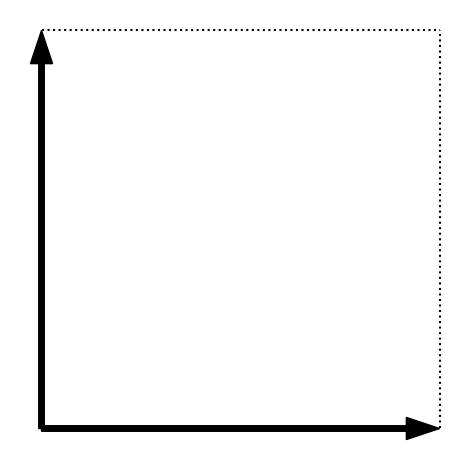

In [4]:
# Define tight binding model for tbplas

# Empty cell
vectors = geometry.cell
cell = tb.PrimitiveCell(vectors, unit=tb.ANG)
cell.plot()

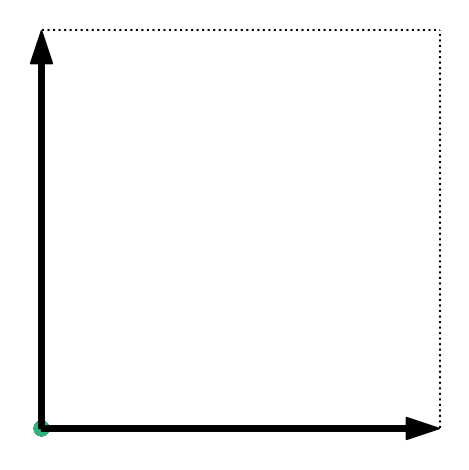

In [5]:
# Add orbitals
positions = geometry.xyz
labels = [[orb.name() for orb in atom] for atom in geometry.atoms]

# To add the orbitals we need the onsite energies.
h = file.read_hamiltonian()
h_mat = h.tocsr().tocoo()

rows = h_mat.row
cols = h_mat.col
data = h_mat.data

# Main diagonal length:
n_diag = min(h_mat.shape[0], h_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# onsites = 
add_orbitals(cell, positions, onsites, labels)
cell.plot()

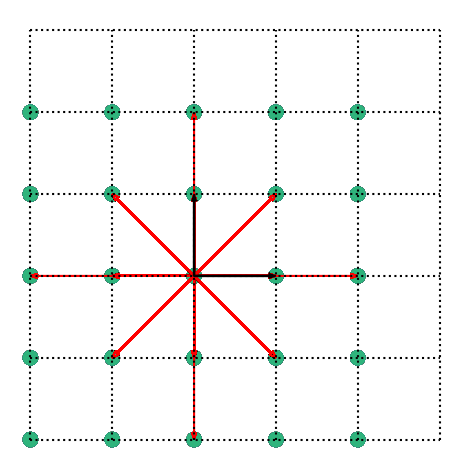

In [6]:
# Add hopping terms.
# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = len(positions)
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
        

add_hopping_terms(cell, iscs, orbs_in, orbs_out, hoppings)
cell.plot()

In [7]:
# Get overlap

# To add the orbitals we need the onsite energies.
o = file.read_overlap()
o_mat = o.tocsr().tocoo()

rows = o_mat.row
cols = o_mat.col
data = o_mat.data

# Main diagonal length:
n_diag = min(o_mat.shape[0], o_mat.shape[1])

# Loop through all diagonal elements
onsites = np.zeros(n_diag, dtype=data.dtype)
for i in range(n_diag):
    # Find where both row and col equal i
    mask = (rows == i) & (cols == i)
    vals = data[mask]
    if len(vals) > 0:
        onsites[i] = vals[0]  # In COO, there could be duplicates, but take the first
    else:
        onsites[i] = 0  # Or np.nan if you prefer

# Add onsites to overlap
overlap = tb.PrimitiveCell(cell.lat_vec, cell.origin, 1.0)
for i in range(cell.num_orb):
    orbital = cell.orbitals[i]
    overlap.add_orbital(orbital.position, onsites[i])


# Add hopping terms to overlap

# We need to iterate though each nnz element of h and get the isc in a tuple, the orb_in, the orb_out and the hopping value.
nnz = len(data)
n_orbs = len(labels[0]) # Assuming all atoms have the same nr of orbitals
n_atoms = len(positions)
iscs = []
orbs_in = []
orbs_out = []
hoppings = []
for k in range(nnz):
    row = rows[k]
    col = cols[k]
    if row != col:  # Only add hopping terms for off-diagonal elements
        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (n_atoms*n_orbs))
        orbs_out.append(row)
        hoppings.append(data[k])
        

add_hopping_terms(overlap, iscs, orbs_in, orbs_out, hoppings)


Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : Test

Using Eigen backend for diagonalization.
	 bands :    0.01354


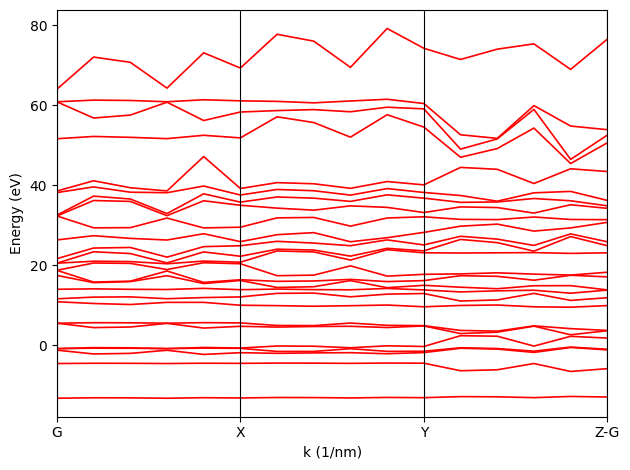

In [13]:
# Calculations

# Define a path in k-space
k_dir_x = geometry.rcell[:,0]
k_dir_y = geometry.rcell[:,1]
k_dir_z = geometry.rcell[:,2]
k_points = np.array([
    [0.0, 0.0, 0.0],    # Gamma
    k_dir_x,
    k_dir_x + k_dir_y,
    k_dir_x + k_dir_y + k_dir_z
])
k_points = np.array([[0, 0, 0], [0, 0, 1]]) if debug_mode else k_points
k_label = ["G", "X", "Y", "Z-G"] if not debug_mode else ["G", "X-G"]

n_ks = 5
k_path, k_idx = tb.gen_kpath(k_points, [n_ks, n_ks, n_ks])


# Bands
use_diag_solver = True
if use_diag_solver:
    solver = tb.DiagSolver(cell, overlap)
    solver.config.k_points = k_path
    solver.config.prefix = "Test"
    timer = tb.Timer()
    timer.tic("bands")
    k_len, bands = solver.calc_bands()
    timer.toc("bands")
else:
    k_len, bands = tb.calc_bands(cell, k_path, prefix="graphene")

vis = tb.Visualizer()
timer.report_total_time()
fig_bands = vis.plot_bands(k_len, bands, k_idx, k_label)



Parallelization details:
  MPI disabled    
  OMP_NUM_THREADS  : n/a   
  MKL_NUM_THREADS  : n/a   

Output details:
  Directory  : ./
  Prefix     : sample

Using Eigen backend for diagonalization.


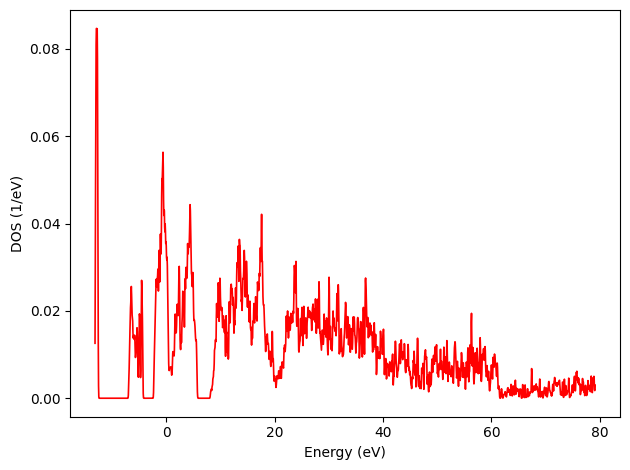

In [15]:
# DOS
k_mesh = tb.gen_kmesh((3*n_ks, 3*n_ks, 3*n_ks))  # Uniform meshgrid
e_min = float(np.min(bands))
e_max = float(np.max(bands))
if use_diag_solver:
    solver = tb.DiagSolver(cell, overlap)
    solver.config.k_points = k_mesh
    # solver.config.prefix = "graphene"
    solver.config.e_min = e_min
    solver.config.e_max = e_max
    timer = tb.Timer()
    timer.tic("dos")
    energies, dos = solver.calc_dos()
    timer.toc("dos")
else:
    energies, dos = tb.calc_dos(cell, k_mesh, e_min=e_min, e_max=e_max)

vis = tb.Visualizer()
fig_dos = vis.plot_dos(energies, dos)

In [17]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_energy_bands(k_path, array_true, array_pred=None, titles_true=None, titles_pred=None, xlabel=None, ylabel=None, title=None, filepath=None):

    if array_pred.ndim != 2:
        raise ValueError("Input array must be 2-dimensional")

    num_rows = array_pred.shape[0]
    num_cols = array_pred.shape[1]

    # Default color sequence (you can customize this)

    if titles_pred is None:
        titles_pred = [f'Pred Row {i+1}' for i in range(num_rows)]
    elif len(titles_pred) != num_rows:
        raise ValueError("Number of titles_pred must match number of rows")

    if titles_true is None:
        titles_true = [f'True Row {i+1}' for i in range(num_rows)]
    elif len(titles_true) != num_rows:
        raise ValueError("Number of titles_true must match number of rows")



    fig = go.Figure()

    colors = pc.qualitative.Plotly  # or another palette
    num_colors = len(colors)

    for row in range(num_rows):
        color = colors[row % num_colors]

        # Add predicted values as dashed line 
        fig.add_trace(go.Scatter(
            x=k_path,
            y=array_pred[row],
            mode='lines',
            line=dict(dash='dash', color=color),
            name=titles_pred[row],
            # opacity=0.8,
            legendgroup=f'group{row}',
            showlegend=True
        ))

        if array_true is not None:
            # Add true values as solid line with same color 
            fig.add_trace(go.Scatter(
                x=k_path,
                y=array_true[row],
                mode='lines',
                line=dict(dash='solid', color=color),
                name=titles_true[row],
                # opacity=0.8,
                legendgroup=f'group{row}',
                showlegend=True
            ))

    fig.update_layout(
        title=title,
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        # hovermode='x unified',
        height=800,
        xaxis_title_standoff=15,
    )

    fig.update_xaxes(
        showticklabels=False,
    )

    # === Output ===
    if filepath:
        filepath = filepath
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath))
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
    else:
        fig.show()

    return fig



def plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None):
    """
    Plot band structure using Plotly.

    Parameters:
    - k_len: array-like, k-point distances
    - bands: 2D array, shape (n_kpoints, n_bands), true bands
    - k_idx: list of indices where vertical lines are drawn
    - k_label: list of labels for xticks
    - predicted_bands: optional 2D array, same shape as `bands`
    """
    fig = go.Figure()
    num_bands = bands.shape[1]

    # True bands: solid black
    for i in range(num_bands):
        fig.add_trace(go.Scatter(
            x=k_len,
            y=bands[:, i],
            mode='lines',
            name=f'True Band {i+1}',
            line=dict(color='black', width=1, dash='solid'),
            legendgroup=f'Band {i+1}',
            showlegend=True if predicted_bands is None else False
        ))

    # Predicted bands: dashed black
    if predicted_bands is not None:
        for i in range(num_bands):
            fig.add_trace(go.Scatter(
                x=k_len,
                y=predicted_bands[:, i],
                mode='lines',
                name=f'Predicted Band {i+1}',
                line=dict(color='black', width=1, dash='dash'),
                legendgroup=f'Band {i+1}',
                showlegend=True
            ))

    # Vertical lines
    for idx in k_idx:
        fig.add_shape(type="line",
                      x0=k_len[idx], y0=bands.min(), x1=k_len[idx], y1=bands.max(),
                      line=dict(color="black", width=1))

    # Layout
    fig.update_layout(
        xaxis=dict(
            title="k (1/nm)",
            tickmode='array',
            tickvals=[k_len[i] for i in k_idx],
            ticktext=k_label,
            ticks='',  # Hide tick marks
            showticklabels=True,
            range=[0, k_len.max()]
        ),
        yaxis=dict(title="Energy (eV)"),
        margin=dict(l=50, r=20, t=20, b=50),
        showlegend=True
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig



def plot_dos(energies, dos, predicted_dos=None, filepath=None):
    """
    Plot Density of States (DOS) vertically with Energy on y-axis.

    Parameters:
    - energies: array-like, energy values (eV)
    - dos: array-like, true DOS values
    - predicted_dos: optional array-like, predicted DOS values (same shape as dos)
    """
    fig = go.Figure()

    # True DOS
    fig.add_trace(go.Scatter(
        x=dos,
        y=energies,
        mode='lines',
        name='True',
        line=dict(color='black', width=1, dash='solid')
    ))

    # Predicted DOS
    if predicted_dos is not None:
        fig.add_trace(go.Scatter(
            x=predicted_dos,
            y=energies,
            mode='lines',
            name='Pred',
            line=dict(color='black', width=1, dash='dash')
        ))

    # Layout
    fig.update_layout(
        xaxis=dict(title='DOS (1/eV)'),
        yaxis=dict(title='Energy (eV)'),
        margin=dict(l=50, r=50, t=20, b=20),
        showlegend=True
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig


def combine_band_and_dos(fig_band, fig_dos, filepath=None):
    """
    Combine band structure and DOS plots side by side into a single figure.

    Parameters:
    - fig_band: Plotly figure from plot_bands()
    - fig_dos: Plotly figure from plot_dos()

    Returns:
    - Combined Plotly figure
    """
    # Create 1-row, 2-column subplot
    fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                        column_widths=[0.75, 0.25],
                        horizontal_spacing=0.02,
                        specs=[[{"type": "xy"}, {"type": "xy"}]])

    # Add band traces to subplot (1,1)
    for trace in fig_band.data:
        fig.add_trace(trace, row=1, col=1)

    # Add DOS traces to subplot (1,2)
    for trace in fig_dos.data:
        fig.add_trace(trace, row=1, col=2)

    # Update layout
    fig.update_layout(
        xaxis=dict(title='k (1/nm)'),  # subplot (1,1)
        xaxis2=dict(title='DOS (1/eV)'),  # subplot (1,2)
        yaxis=dict(title='Energy (eV)'),  # shared y-axis
        showlegend=True,
        margin=dict(l=50, r=20, t=20, b=40)
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig

In [19]:
# filepath = savedir_struct / f"{n_atoms}atm_{structure}_bands.html"
fig_bands = plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None)
# filepath = savedir_struct / f"{n_atoms}atm_{structure}_dos.html"
fig_dos = plot_dos(energies, dos, predicted_dos=None, filepath=None)
# filepath = savedir_struct / f"{n_atoms}atm_{structure}_bandsdos.html"
combine_band_and_dos(fig_bands, fig_dos, filepath=None)
None